### Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import tldextract

from urllib.parse import urlparse

sns.set(style="whitegrid")
sns.set_palette("pastel")

### Read dataset

In [2]:
df = pd.read_csv('../data/furniture stores pages.csv')

# Rename column "max(page)" to "url"
df.rename(columns={'max(page)':'url'}, inplace=True)

### Exploratory Data Analysis

Check the number of URL's

In [3]:
print(f"The dataframe has {df.shape[0]} url's")

The dataframe has 704 url's


Remove duplicates if there are any

In [4]:
# Get the number of rows before removing duplicates
original_rows = df.shape[0]

df = df.drop_duplicates()
num_duplicates = original_rows - df.shape[0]
print(f"The dataframe has {num_duplicates} duplicate URL(s)")

The dataframe has 0 duplicate URL(s)


Check for missing values

In [5]:
# Check for missing values
missing_values = df.isnull().sum()

if missing_values.sum() > 0:
    print("There are missing values in the DataFrame")
    df = df.dropna()
else:
    print("There are no missing values in the DataFrame")

There are no missing values in the DataFrame


Check the website distribution (the domain of where the data is coming from)

In [6]:
df['domain'] = df['url'].apply(lambda url: urlparse(url).netloc.replace('www.', ''))
domain_counts = df['domain'].value_counts()

# Count the domains having more than one appearance
frequent_domains = domain_counts[domain_counts > 1]
# df.url.to_list()

In [7]:
print(f"It looks like we have {len(frequent_domains)} domains appearing more than once")

It looks like we have 0 domains appearing more than once


Let's take a look at the URL structure!

In [8]:
def parse_urls(df, url_column='url'):
    # We parse the URL's to break 'em down into their components
    df['parsed_url'] = df[url_column].apply(urlparse)
    # Create a protocol column
    df['protocol'] = df['parsed_url'].apply(lambda url: 0 if url.scheme == 'http' else (1 if url.scheme == 'https' else None))
    # Create a top-level domain column consisting of the business nature and the country code
    df['tld'] = df[url_column].apply(lambda url: tldextract.extract(url).suffix)
    # Create a generic top-level domain column 
    df['generic_tld'] = df['tld'].apply(lambda tld: tld.split('.')[0] if len(tld.split('.')) > 1 else tld)
    # Create a country code top-level domain column
    df['country_code_tld'] = df['tld'].apply(lambda tld: tld.split('.')[1] if len(tld.split('.')) > 1 else None)
    return df

df = parse_urls(df)

In [9]:
http_protocols = len(df[df['protocol'] == 0])
https_protocols = len(df[df['protocol'] == 1])

print(f"HTTP protocol URL's: {http_protocols} ({round(((http_protocols / df.shape[0]) * 100), 3)}%)")
print(f"HTTPS protocol URL's: {https_protocols} ({round(((https_protocols / df.shape[0]) * 100), 3)}%)")

HTTP protocol URL's: 31 (4.403%)
HTTPS protocol URL's: 673 (95.597%)


In [10]:
tld_counts = df['tld'].value_counts()
generic_tld_counts = df['generic_tld'].value_counts()
country_code_tld_counts = df['country_code_tld'].value_counts()

# Create an "Other" category for value_counts less than 1%
mask = df['country_code_tld'].map(country_code_tld_counts) / len(df) < 0.01
df.loc[mask, 'country_code_tld'] = 'others'
country_code_tld_counts = df['country_code_tld'].value_counts()

Geographical Visualization

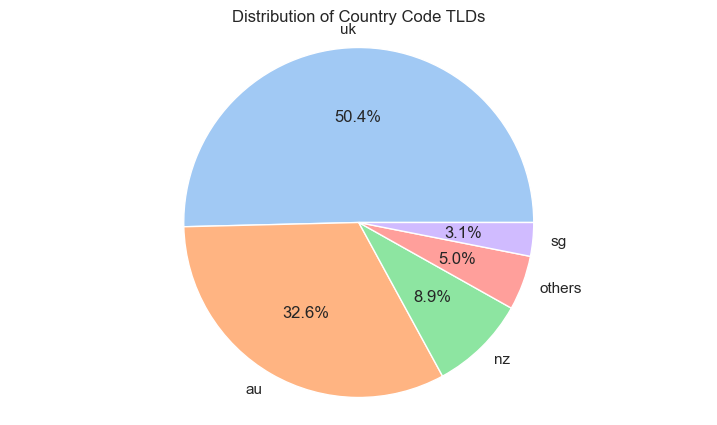

In [11]:
plt.figure(figsize=(9, 5))
plt.title('Distribution of Country Code TLDs')

plt.pie(country_code_tld_counts,
        labels=country_code_tld_counts.index,
        autopct='%1.1f%%')
plt.axis('equal')
plt.show()

TLD's Visualization

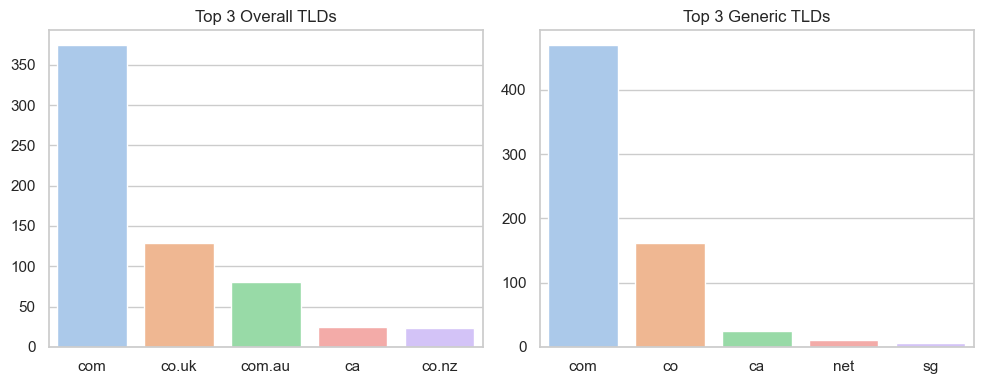

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=False)

# Plot for TLD's
sns.barplot(x=tld_counts[:5].index, y=tld_counts[:5].values, ax=axes[0])
axes[0].set_title('Top 3 Overall TLDs', fontsize=12)

# Plot for generic TLD's
sns.barplot(x=generic_tld_counts[:5].index, y=generic_tld_counts[:5].values, ax=axes[1])
axes[1].set_title('Top 3 Generic TLDs', fontsize=12)

plt.tight_layout()
plt.show()

- The most common top-level domain in our dataset was '.com', which appeared 374 times. The '.co.uk' and '.com.au' domains were also fairly common, with 129 and 81 occurrences, respectively. 
- When looking at the generic TLD's, '.com' was again the most common, with '.co' and '.ca' following. 
- The most common country code TLD's were '.uk', '.au', and '.nz'.

### Export the dataframe

In [13]:
df.to_csv('../data/preprocessed_data.csv', index=False)